In [1]:
import tensorflow as tf
import pandas as pd 
#from keras.utils import to_categorical
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
# Define Constants by re-sizing all the images
IMAGE_SIZE = [224, 224]

train_dir='drive/MyDrive/copy/ne/train'
validation_dir='drive/MyDrive/copy/ne/valid'
test_dir='drive/MyDrive/copy/ne/test'

In [3]:
#rom keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False,
                                                      input_shape=(224, 224, 3))


58892288/58889256 [==============================] - 1s 0us/step


In [4]:
# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [20]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [6]:
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [22]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", 
optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
# Using the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)
valid_datagen=ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
# Training Generator
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 18014 images belonging to 10 classes.


In [10]:
# Testing Generator
validation_set = valid_datagen.flow_from_directory(validation_dir,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


In [14]:
# Testing Generator
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 10
                                            )

Found 330 images belonging to 10 classes.


In [15]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=True,
monitor='val_acc',
mode='max',
save_best_only=True)

In [24]:
# fit the model, it will take some time to execute
r = transfer_model.fit_generator(
  training_set,
  steps_per_epoch=len(training_set)//32,
  epochs=50,
  validation_data=validation_set,
  validation_steps=len(validation_set)/16)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
17/17 [==============================] - 199s 12s/step - loss: 2.0216 - accuracy: 0.2886 - val_loss: 1.6677 - val_accuracy: 0.4965
Epoch 2/50
17/17 [==============================] - 194s 12s/step - loss: 1.7378 - accuracy: 0.4265 - val_loss: 1.3499 - val_accuracy: 0.5938
Epoch 3/50
17/17 [==============================] - 190s 11s/step - loss: 1.3974 - accuracy: 0.5533 - val_loss: 1.0801 - val_accuracy: 0.6424
Epoch 4/50
17/17 [==============================] - 177s 11s/step - loss: 1.2889 - accuracy: 0.5680 - val_loss: 0.9830 - val_accuracy: 0.6806
Epoch 5/50
17/17 [==============================] - 177s 11s/step - loss: 1.2132 - accuracy: 0.5919 - val_loss: 0.8499 - val_accuracy: 0.7222
Epoch 6/50
17/17 [==============================] - 164s 10s/step - loss: 0.9500 - accuracy: 0.6710 - val_loss: 0.8593 - val_accuracy: 0.7188
Epoch 7/50
17/17 [==============================] - 145s 9s/step - loss: 0.8491 - accuracy: 0.7261 - val_loss: 0.8267 - val_accuracy: 0.7153
Epoch 8

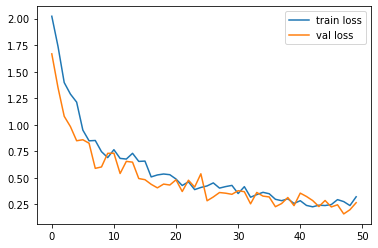

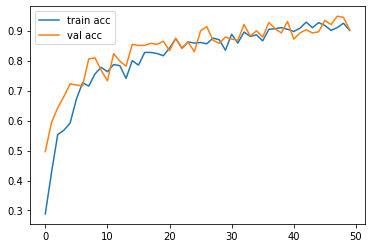

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot the Loss and Accuracy
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [26]:
# Saving the model as a h5 file

from tensorflow.keras.models import load_model
transfer_model.save('transfer_for new.h5')

In [46]:
model.metrics_names

['loss', 'accuracy']

In [48]:
score=model.evaluate_generator(test_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [49]:
score

[0.3749517798423767, 0.8696969747543335]

In [40]:
prediction = transfer_model.predict(test_set)
prediction

array([[8.8435274e-07, 2.2118144e-05, 4.6256617e-05, ..., 1.3395420e-06,
        5.2853069e-05, 2.4097167e-07],
       [2.1111590e-04, 1.2573690e-02, 6.4633598e-05, ..., 1.2549388e-04,
        4.2566154e-03, 4.1131349e-03],
       [1.0183354e-06, 1.1971560e-03, 1.5496693e-06, ..., 1.2678991e-05,
        2.5384612e-03, 1.2955198e-04],
       ...,
       [3.3267781e-05, 5.8691389e-06, 9.8058175e-09, ..., 9.9994135e-01,
        3.8979210e-06, 1.7671232e-07],
       [8.7140268e-04, 9.6124259e-04, 1.0511974e-04, ..., 7.5915479e-05,
        3.5182358e-04, 2.3829129e-04],
       [2.3559445e-05, 5.0627645e-03, 2.2106981e-04, ..., 4.8680713e-06,
        7.8310193e-05, 3.2802533e-02]], dtype=float32)

In [41]:
import numpy as np
y_pred = np.argmax(prediction, axis=1)
y_pred

array([3, 6, 5, 7, 5, 8, 9, 5, 2, 3, 7, 6, 9, 8, 0, 9, 7, 5, 6, 8, 0, 8,
       1, 8, 5, 5, 7, 8, 1, 8, 6, 0, 7, 5, 5, 4, 7, 3, 7, 5, 5, 4, 0, 4,
       7, 4, 9, 6, 4, 9, 2, 6, 6, 7, 3, 6, 0, 6, 5, 7, 1, 7, 0, 7, 8, 0,
       8, 6, 4, 3, 8, 7, 5, 0, 3, 9, 7, 8, 5, 9, 7, 2, 5, 0, 5, 2, 2, 5,
       1, 7, 1, 8, 5, 0, 9, 8, 1, 0, 8, 2, 0, 1, 5, 3, 4, 3, 1, 7, 6, 9,
       7, 5, 5, 9, 5, 4, 9, 3, 9, 8, 6, 9, 0, 0, 0, 9, 3, 3, 1, 3, 1, 1,
       8, 8, 9, 1, 6, 0, 4, 4, 4, 6, 7, 9, 3, 8, 3, 9, 8, 5, 8, 2, 2, 4,
       0, 0, 4, 1, 6, 0, 8, 6, 2, 1, 0, 8, 2, 9, 7, 4, 0, 0, 5, 6, 4, 5,
       1, 6, 8, 6, 6, 3, 6, 8, 9, 4, 1, 1, 3, 0, 4, 0, 8, 7, 9, 8, 5, 4,
       2, 5, 1, 0, 2, 5, 7, 0, 3, 0, 4, 9, 1, 0, 6, 8, 7, 9, 3, 9, 8, 4,
       6, 5, 8, 0, 6, 0, 3, 6, 0, 3, 3, 0, 5, 4, 3, 5, 8, 6, 4, 5, 4, 3,
       1, 0, 5, 2, 1, 8, 6, 4, 1, 7, 4, 1, 1, 5, 6, 7, 6, 2, 6, 9, 2, 2,
       9, 8, 6, 0, 1, 6, 4, 6, 4, 4, 1, 2, 5, 3, 9, 5, 6, 0, 8, 7, 3, 4,
       2, 0, 2, 4, 7, 9, 3, 3, 9, 9, 9, 1, 0, 2, 9,

In [29]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np


model = keras.models.load_model('transfer_for new.h5')

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

# inspect the layers operations inside your frozen graph definition and see the name of its input and output tensors
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
# serialize the frozen graph and its text representation to disk.
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pb",
                  as_text=False)

#Optional
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pbtxt",
                as_text=True)

--------------------------------------------------
Frozen model layers: 
x
model_1/block1_conv1/Conv2D/ReadVariableOp/resource
model_1/block1_conv1/Conv2D/ReadVariableOp
model_1/block1_conv1/Conv2D
model_1/block1_conv1/BiasAdd/ReadVariableOp/resource
model_1/block1_conv1/BiasAdd/ReadVariableOp
model_1/block1_conv1/BiasAdd
model_1/block1_conv1/Relu
model_1/block1_conv2/Conv2D/ReadVariableOp/resource
model_1/block1_conv2/Conv2D/ReadVariableOp
model_1/block1_conv2/Conv2D
model_1/block1_conv2/BiasAdd/ReadVariableOp/resource
model_1/block1_conv2/BiasAdd/ReadVariableOp
model_1/block1_conv2/BiasAdd
model_1/block1_conv2/Relu
model_1/block1_pool/MaxPool
model_1/block2_conv1/Conv2D/ReadVariableOp/resource
model_1/block2_conv1/Conv2D/ReadVariableOp
model_1/block2_conv1/Conv2D
model_1/block2_conv1/BiasAdd/ReadVariableOp/resource
model_1/block2_conv1/BiasAdd/ReadVariableOp
model_1/block2_conv1/BiasAdd
model_1/block2_conv1/Relu
model_1/block2_conv2/Conv2D/ReadVariableOp/resource
model_1/block2_conv2

'./frozen_models/simple_frozen_graph.pbtxt'

In [43]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import itertools
cm = confusion_matrix(y_true=test_set.classes, y_pred=np.argmax(prediction, axis=-1))
classes=10

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 2 1 2 0 6 4 5 7 3]
 [4 1 1 2 5 5 5 7 1 2]
 [4 3 3 2 1 6 1 4 6 3]
 [4 5 1 6 2 4 2 2 1 6]
 [5 3 3 2 5 1 4 1 6 3]
 [4 3 1 2 5 3 5 2 5 3]
 [7 2 2 5 2 3 4 2 3 3]
 [2 5 4 2 5 5 5 2 2 1]
 [3 2 3 4 5 2 4 2 2 6]
 [2 2 4 3 6 6 2 4 2 2]]


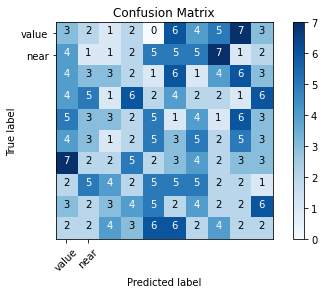

In [50]:
cm_plot_labels = ['value','near']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [58]:
num_of_test_samples =330
test_set.class_indices
batch_size=9
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_set, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight','Tomato___Leaf_Mold',
                'Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
                'Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus','Tomato___healthy']
print(classification_report(test_set.classes, y_pred, target_names=target_names))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[2 4 2 1 5 4 4 6 5 0]
 [4 3 1 6 2 3 2 3 1 8]
 [3 2 3 3 5 4 6 3 3 1]
 [2 2 3 4 1 3 3 2 6 7]
 [8 2 2 2 0 7 5 3 2 2]
 [8 3 1 3 5 5 1 3 2 2]
 [2 4 2 2 4 5 4 0 3 7]
 [2 3 5 5 4 3 3 5 2 1]
 [6 2 1 1 8 2 2 2 6 3]
 [1 3 3 3 2 5 6 4 5 1]]
Classification Report
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.05      0.06      0.06        33
                        Tomato___Early_blight       0.11      0.09      0.10        33
                         Tomato___Late_blight       0.13      0.09      0.11        33
                           Tomato___Leaf_Mold       0.13      0.12      0.13        33
                  Tomato___Septoria_leaf_spot       0.00      0.00      0.00        33
Tomato___Spider_mites Two-spotted_spider_mite       0.12      0.15      0.14        33
                         Tomato___Target_Spot       0.11      0.12      0.12        33
                Tomato_Yellow_Lea